In [1]:
import warnings
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

warnings.filterwarnings("ignore")

set_config(display='diagram')

In [2]:
#https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle
def NumPyRMSLE(y_true:list, y_pred:list) -> float:
    """
        The Root Mean Squared Log Error (RMSLE) metric using only NumPy
        N.B. This function is a lot slower than sklearn's implementation
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    n = len(y_true)
    msle = np.mean([(np.log(y_pred[i] + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

In [3]:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
import sklearn

def aget_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [140]:
from numpy import log
from datetime import date, datetime

def GenerateFeatures(data):

    data.loc[:, 'SMC'] = data['absolute_humidity'] * 100 / data["relative_humidity"]
    data.loc[:, 'DewPoint'] = 243.12*( log(data["relative_humidity"]/100) + ( (17.625*data["deg_C"]) / (243.12+ data["deg_C"])) ) / (17.625 - log(data["relative_humidity"]/100) - ( (17.625*data["deg_C"]) / (243.12+data["deg_C"])))

    data.date_time = data.apply(pd.to_datetime)

    data.loc[:, 'hour'] = data.date_time.dt.hour
    data.loc[:, 'day_of_week'] = data.date_time.dt.dayofweek

    start_date = pd.to_datetime(date(2010, 3, 10)) #where the dataset beggins
    data.loc[:, 'days_since_beg_of_time'] = [(a_date - start_date).days for a_date in data.date_time]

    #data.loc[:, 'bad_sensor_readings'] = (data.target_benzene == 0.1).astype(int)
    data.loc[:, 'post_no_pattern_change'] = (data.date_time > '2010-09-01').astype(int) #data is approximate
    
    #abs(data.date_time - start_date).days
    # data.loc[:, 'is_weekend'] = (data.date_time.dt.dayofweek > 5).astype(int) # no importance to lgbm
  
    return data

In [141]:
#aget_feature_names(ct)

#data = pd.read_csv('data/train.csv')
#data[data.date_time > '2010-09-01']
#data.iloc[4182:,]

In [142]:
# Cross validation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.metrics import make_scorer, mean_squared_log_error
import lightgbm as lgb
from numpy import mean

# read da data
data = pd.read_csv('data/train.csv')

#feature generation
data = GenerateFeatures(data)
data = data[:-1] #drop last row -- single date in new year / don't do it in generate features or it also affects final scoring
groups = data.date_time.dt.to_period("Q")
data.drop(['date_time'], 1, inplace=True)

# prepare the data
target_columns = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides' ]

y = data[target_columns]
X = data[data.columns.difference(target_columns, sort=False)] # leave the sort in, or difference will sort and mess up the predict() because of column ordering

# create pipeline
numerical_columns_selector = selector(dtype_include='float64')
numerical_columns = numerical_columns_selector(X)

ct = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), numerical_columns),
        ('onehot', OneHotEncoder(), ['day_of_week']),
        # ('poly_feat_gen', PolynomialFeatures(), numerical_columns), # leads to sligh worsening of results
    ],
    remainder='passthrough'
)

column_names = numerical_columns + ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour', 'days_since_beg_of_time',  'post_no_pattern_change'] #'bad_sensor_readings',

# pd.DataFrame(ct.fit_transform(X), columns=column_names)

cv = TimeSeriesSplit(n_splits = groups.nunique())

pipeline_cm = make_pipeline(ct, lgb.LGBMRegressor(n_estimators=300, max_depth=30, learning_rate=0.05, random_state=42))
pipeline_be = make_pipeline(ct, lgb.LGBMRegressor(n_estimators=300, max_depth=30, learning_rate=0.05, random_state=42))
pipeline_no = make_pipeline(ct, lgb.LGBMRegressor(n_estimators=300, max_depth=30, learning_rate=0.05, random_state=42))

pipeline_cm = TransformedTargetRegressor(regressor=pipeline_cm, transformer=PowerTransformer(method='yeo-johnson'))
pipeline_be = TransformedTargetRegressor(regressor=pipeline_be, transformer=PowerTransformer(method='yeo-johnson'))
pipeline_no = TransformedTargetRegressor(regressor=pipeline_no, transformer=PowerTransformer(method='yeo-johnson'))

#pipeline_cm = make_pipeline(ct, lgb.LGBMRegressor(colsample_bytree=0.7950235059066133, min_child_samples=104, min_child_weight=0.001, num_leaves=33,reg_alpha=2, reg_lambda=20, subsample=0.6199819724507702,  random_state=42))

#pipeline_be = make_pipeline(ct, lgb.LGBMRegressor(colsample_bytree=0.7164831751245166, min_child_samples=104, min_child_weight=1, num_leaves=30, reg_alpha=7, reg_lambda=100, subsample=0.7221143111036306,  random_state=42))

#pipeline_no = make_pipeline(ct, lgb.LGBMRegressor(colsample_bytree=0.514415407376644, min_child_samples=169, min_child_weight=10000.0, num_leaves=47, reg_alpha=7, reg_lambda=5, subsample=0.7271675995702098,  random_state=42))

scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred)), greater_is_better = False)

cv_results_cm = cross_validate(pipeline_cm, X=X, y=y[target_columns[0]], cv=cv, groups=groups, n_jobs=-1, scoring=scorer)
cv_results_cm['test_score'] = -cv_results_cm['test_score']
print(f"CM - The mean sqrt mean_squared_log_error is: ", f"{cv_results_cm['test_score'].mean():.4f} +/- {cv_results_cm['test_score'].std():.4f}")

cv_results_be = cross_validate(pipeline_be, X=X, y=y[target_columns[1]], cv=cv, groups=groups, n_jobs=-1, scoring=scorer)
cv_results_be['test_score'] = -cv_results_be['test_score']
print(f"BE - The mean sqrt mean_squared_log_error is: ", f"{cv_results_be['test_score'].mean():.4f} +/- {cv_results_be['test_score'].std():.4f}")

cv_results_no = cross_validate(pipeline_no, X=X, y=y[target_columns[2]], cv=cv, groups=groups, n_jobs=-1, scoring=scorer)
cv_results_no['test_score'] = -cv_results_no['test_score']
print(f"NO - The mean sqrt mean_squared_log_error is: ", f"{cv_results_no['test_score'].mean():.4f} +/- {cv_results_no['test_score'].std():.4f}")

print(f"Mean of means: ", f"{mean([cv_results_no['test_score'].mean(), cv_results_be['test_score'].mean(), cv_results_no['test_score'].mean()]):.4f} ")

CM - The mean sqrt mean_squared_log_error is:  0.1417 +/- 0.0492
BE - The mean sqrt mean_squared_log_error is:  0.1002 +/- 0.0065
NO - The mean sqrt mean_squared_log_error is:  0.3495 +/- 0.0686
Mean of means:  0.2664 


In [145]:
#cv_results_no
#numerical_columns
pipeline_cm

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['deg_C',
                                                                                        'relative_humidity',
                                                                                        'absolute_humidity',
                                                                                        'sensor_1',
                                                                                        'sensor_2',
                                                                                        'sensor_3',
                                                                                        'sensor_4',
                                                                                        'sensor_5',
                                                                                        'SMC',
                                                                                        'DewPoint']),
                                                                                      ('onehot',
                                                                                       OneHotEncoder(),
                                                                                       ['day_of_week'])])),
                                                     ('lgbmregressor',
                                                      LGBMRegressor(learning_rate=0.05,
                                                                    max_depth=30,
                                                                    n_estimators=300,
                                                                    random_state=42))]),
                           transformer=PowerTransformer())

In [146]:
# Train models on the entire dataset (I don't like this idea...)
model_cm = pipeline_cm.fit(X, y[target_columns[0]])
print('Trained model for Carbon Monoxide')
model_be = pipeline_be.fit(X, y[target_columns[1]])
print('Trained model for Benzene')

#y[target_columns[2]].iloc[:4181,] = y[target_columns[2]].iloc[:4181,]*2.86
#model_no = pipeline_no.fit(X.iloc[4182:,], y[target_columns[2]].iloc[4182:,])
model_no = pipeline_no.fit(X, y[target_columns[2]])
print('Trained model for Nitrogen Oxide')

Trained model for Carbon Monoxide
Trained model for Benzene
Trained model for Nitrogen Oxide


In [147]:
#Load test dataset
test_data = pd.read_csv('data/test.csv')

# make submission predictions
test_data = GenerateFeatures(test_data)
date_time_col = test_data.pop('date_time')

holdout_pred_cm = pipeline_cm.predict(test_data)
holdout_pred_be = pipeline_be.predict(test_data)
holdout_pred_no = pipeline_no.predict(test_data)

# prepare result dataframe
test_data['target_carbon_monoxide'] = holdout_pred_cm
test_data['target_benzene'] = holdout_pred_be
test_data.target_benzene = np.where((test_data.target_benzene < 0.3), 0.1, test_data.target_benzene) # hammer results when the sensors are bad
test_data['target_nitrogen_oxides'] = holdout_pred_no

# fix columns
test_data['date_time'] = date_time_col
data_to_save = test_data[['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

# save to file
data_to_save.reset_index()
data_to_save.to_csv('data/holdout_predictions.csv', index=False)

print("Predictions file saved")

Predictions file saved


# Hyperparameter tuning

In [117]:
# Do some hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#param_dist = {  'lgbmregressor__n_estimators': [100, 150, 200, 250, 300],
#                'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
#                'lgbmregressor__max_depth': [15, 20, 25, 30],
                #'lgbmregressor__num_leaves': 32,
                #'lgbmregressor__feature_fraction': 0.8,
                #'lgbmregressor__subsample': 0.2
#                }

# https://www.kaggle.com/rtatman/lightgbm-hyperparameter-optimisation-lb-0-761
# clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
param_dist ={'lgbmregressor__num_leaves': sp_randint(6, 50), 
            'lgbmregressor__min_child_samples': sp_randint(100, 500), 
            'lgbmregressor__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'lgbmregressor__subsample': sp_uniform(loc=0.2, scale=0.8), 
            'lgbmregressor__colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
            'lgbmregressor__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'lgbmregressor__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_iterations_to_run = 100

randsearch_pipeline_cm = make_pipeline(ct, lgb.LGBMRegressor(max_depth=-1, silent=True, metric='None', n_jobs=-1, n_estimators=5000, random_state=42))
randsearch_pipeline_be = make_pipeline(ct, lgb.LGBMRegressor(max_depth=-1, silent=True, metric='None', n_jobs=-1, n_estimators=5000, random_state=42))
randsearch_pipeline_no = make_pipeline(ct, lgb.LGBMRegressor(max_depth=-1, silent=True, metric='None', n_jobs=-1, n_estimators=5000, random_state=42))

print("starting tunning, iterations: ", n_iterations_to_run)

search_cm = RandomizedSearchCV(randsearch_pipeline_cm, param_distributions=param_dist, cv=5, n_iter=n_iterations_to_run, scoring=scorer)
search_cm.fit(X, y[target_columns[0]]) #[numerical_columns]
print(search_cm.best_params_)
print("search done for cm")

search_be = RandomizedSearchCV(randsearch_pipeline_be, param_distributions=param_dist, cv=5, n_iter=n_iterations_to_run, scoring=scorer)
search_be.fit(X, y[target_columns[1]])
print(search_be.best_params_)
print("search done for be")

search_no = RandomizedSearchCV(randsearch_pipeline_no, param_distributions=param_dist, cv=5, n_iter=n_iterations_to_run, scoring=scorer)
search_no.fit(X, y[target_columns[2]])
print(search_no.best_params_)
print("search done for no")


starting tunning, iterations:  100


KeyboardInterrupt: 

In [112]:
print(search_cm.best_params_)
print(search_be.best_params_)
print(search_no.best_params_)

{'lgbmregressor__colsample_bytree': 0.9911398710271663, 'lgbmregressor__min_child_samples': 100, 'lgbmregressor__min_child_weight': 1e-05, 'lgbmregressor__num_leaves': 39, 'lgbmregressor__reg_alpha': 2, 'lgbmregressor__reg_lambda': 1, 'lgbmregressor__subsample': 0.8782752312741597}
{'lgbmregressor__colsample_bytree': 0.9712441517819296, 'lgbmregressor__min_child_samples': 134, 'lgbmregressor__min_child_weight': 0.1, 'lgbmregressor__num_leaves': 42, 'lgbmregressor__reg_alpha': 5, 'lgbmregressor__reg_lambda': 10, 'lgbmregressor__subsample': 0.8914493066020817}
{'lgbmregressor__colsample_bytree': 0.9329649747359096, 'lgbmregressor__min_child_samples': 218, 'lgbmregressor__min_child_weight': 10000.0, 'lgbmregressor__num_leaves': 24, 'lgbmregressor__reg_alpha': 2, 'lgbmregressor__reg_lambda': 50, 'lgbmregressor__subsample': 0.41884150795790104}


In [114]:
# score on test data

cv_results_cm = cross_validate(search_cm, X=X, y=y[target_columns[0]], cv=cv, groups=groups, n_jobs=-1, scoring=scorer)
cv_results_cm['test_score'] = -cv_results_cm['test_score']
print(f"CM - The mean sqrt mean_squared_log_error is: ", f"{cv_results_cm['test_score'].mean():.4f} +/- {cv_results_cm['test_score'].std():.4f}")

cv_results_be = cross_validate(search_be, X=X, y=y[target_columns[1]], cv=cv, groups=groups, n_jobs=-1, scoring=scorer)
cv_results_be['test_score'] = -cv_results_be['test_score']
print(f"BE - The mean sqrt mean_squared_log_error is: ", f"{cv_results_be['test_score'].mean():.4f} +/- {cv_results_be['test_score'].std():.4f}")

cv_results_no = cross_validate(search_no, X=X, y=y[target_columns[2]], cv=cv, groups=groups, n_jobs=-1, scoring=scorer)
cv_results_no['test_score'] = -cv_results_no['test_score']
print(f"NO - The mean sqrt mean_squared_log_error is: ", f"{cv_results_no['test_score'].mean():.4f} +/- {cv_results_no['test_score'].std():.4f}")

print(f"Mean of means: ", f"{mean([cv_results_no['test_score'].mean(), cv_results_be['test_score'].mean(), cv_results_no['test_score'].mean()]):.4f} ")

CM - The mean sqrt mean_squared_log_error is:  0.1486 +/- 0.0477
BE - The mean sqrt mean_squared_log_error is:  0.1116 +/- 0.0126
NO - The mean sqrt mean_squared_log_error is:  0.3730 +/- 0.0653
Mean of means:  0.2859 


In [115]:
# Write predictions on holdout

#Load test dataset
test_data = pd.read_csv('data/test.csv')

# make submission predictions
test_data = GenerateFeatures(test_data)
date_time_col = test_data.pop('date_time')

holdout_pred_cm = search_cm.predict(test_data)
holdout_pred_be = search_benz.predict(test_data)
holdout_pred_no = search_no.predict(test_data)

# prepare result dataframe
test_data['target_carbon_monoxide'] = holdout_pred_cm
test_data['target_benzene'] = holdout_pred_be
test_data.target_benzene = np.where((test_data.target_benzene < 0.3), 0.1, test_data.target_benzene) # hammer results when the sensors are bad
test_data['target_nitrogen_oxides'] = holdout_pred_no

# fix columns
test_data['date_time'] = date_time_col
data_to_save = test_data[['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

# save to file
data_to_save.reset_index()
data_to_save.to_csv('data/holdout_predictions_tuned.csv', index=False)

print("Predictions file saved")

Predictions file saved


# Look at the results

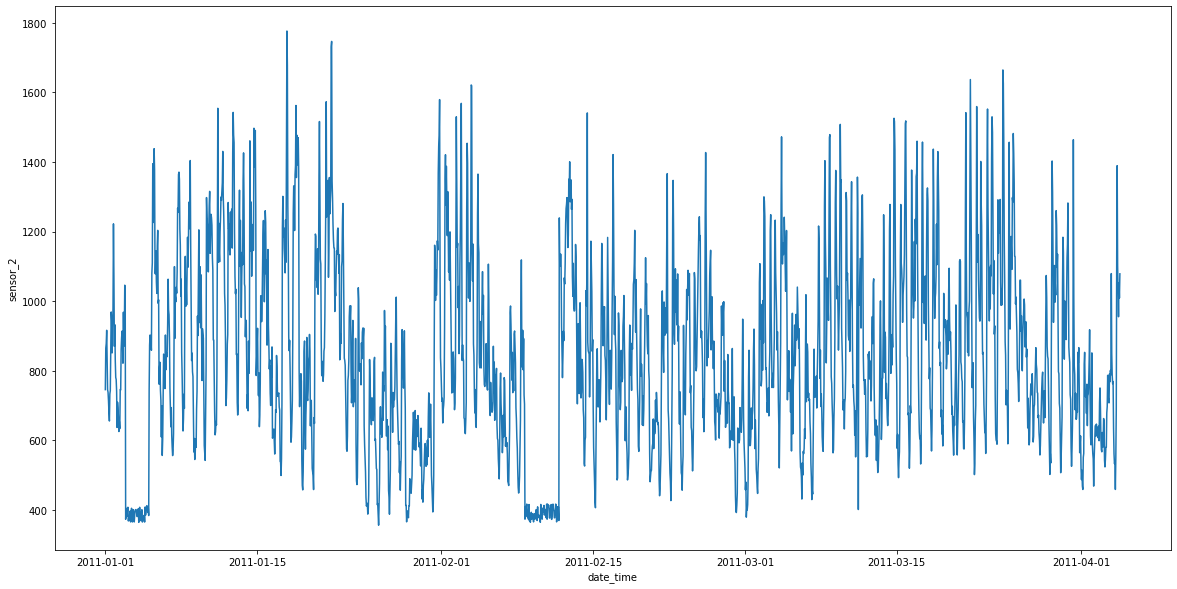

In [21]:
test_data = pd.read_csv('data/test.csv')
test_data.date_time = test_data.apply(pd.to_datetime)

plt.figure(figsize=(20, 10))
sns.lineplot(data=test_data, x='date_time', y='sensor_2')
plt.show()

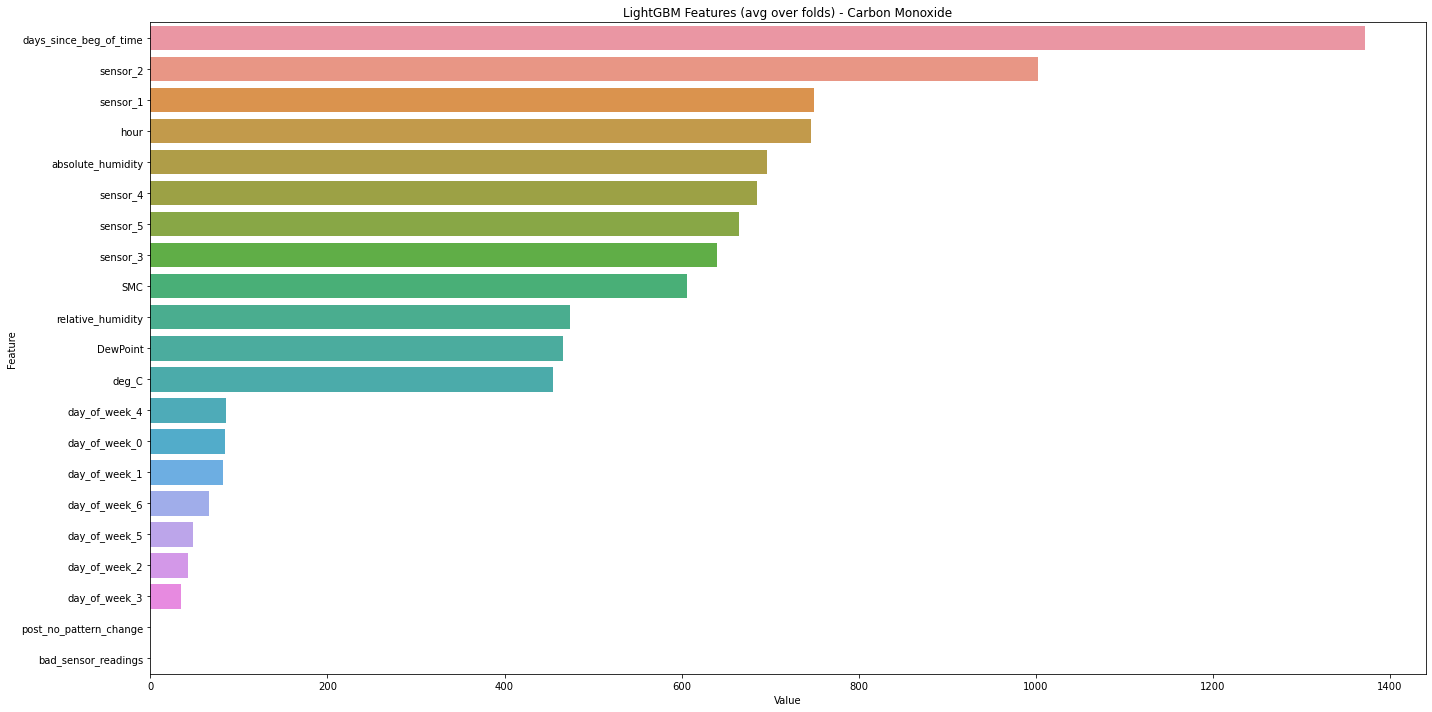

In [125]:
#column_names = aget_feature_names(ct)
feature_imp = pd.DataFrame(sorted(zip(pipeline_cm["lgbmregressor"].feature_importances_,column_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds) - Carbon Monoxide')
plt.tight_layout()
plt.show()

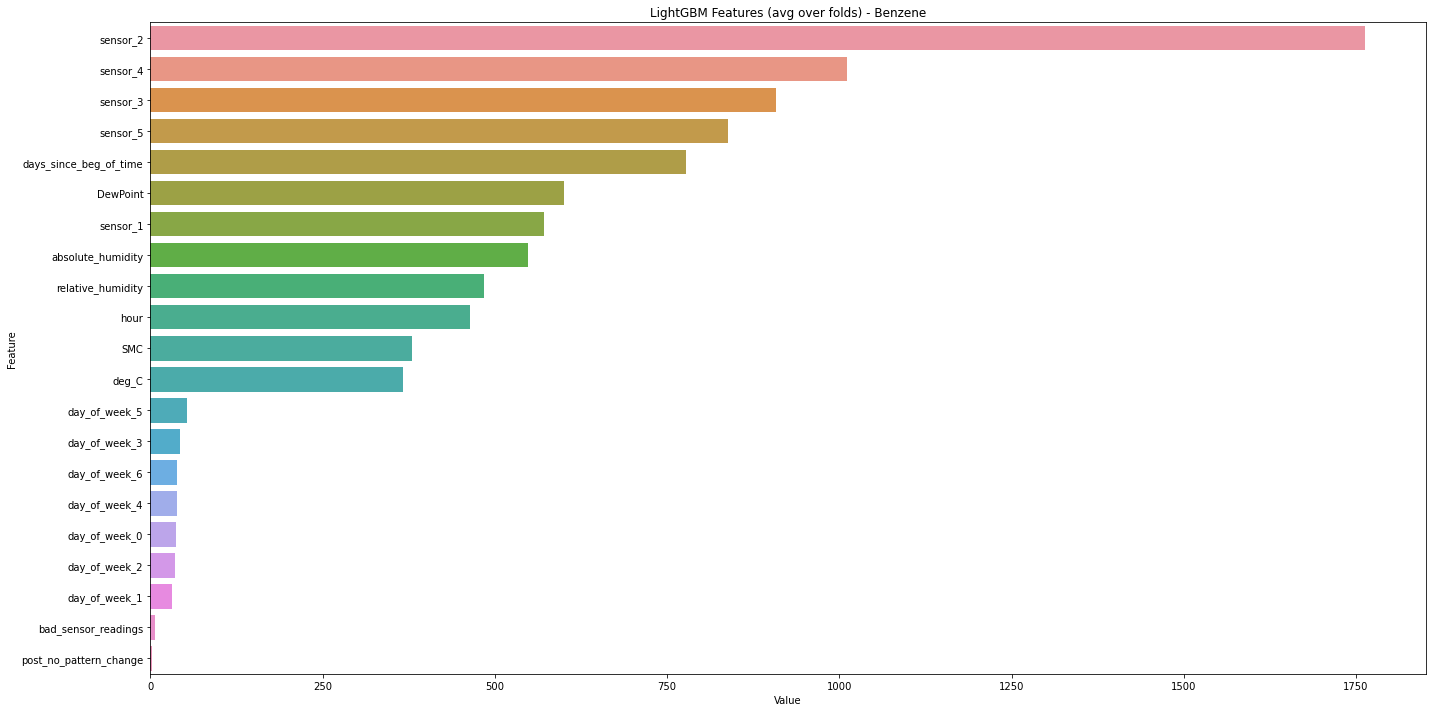

In [126]:
feature_imp = pd.DataFrame(sorted(zip(pipeline_be["lgbmregressor"].feature_importances_,column_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds) - Benzene')
plt.tight_layout()
plt.show()

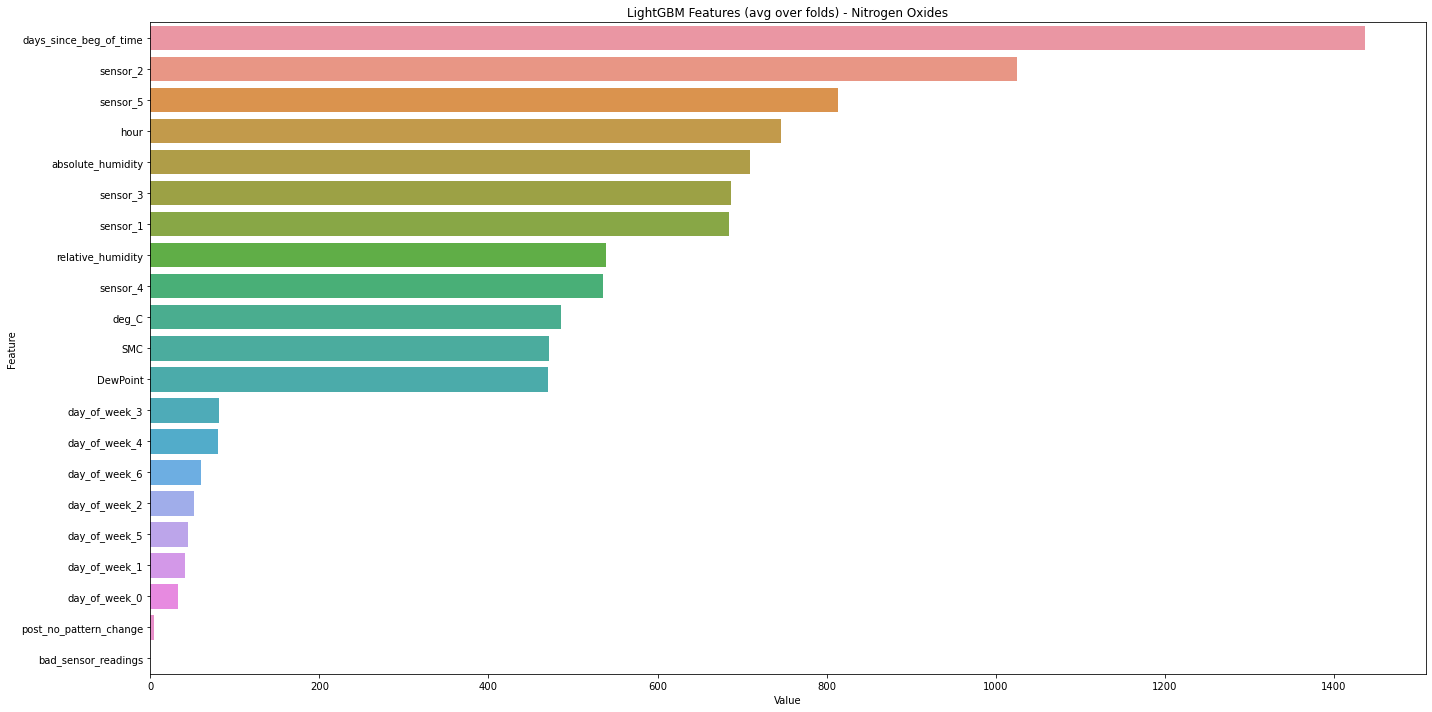

In [127]:
feature_imp = pd.DataFrame(sorted(zip(pipeline_no["lgbmregressor"].feature_importances_,column_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds) - Nitrogen Oxides')
plt.tight_layout()
plt.show()

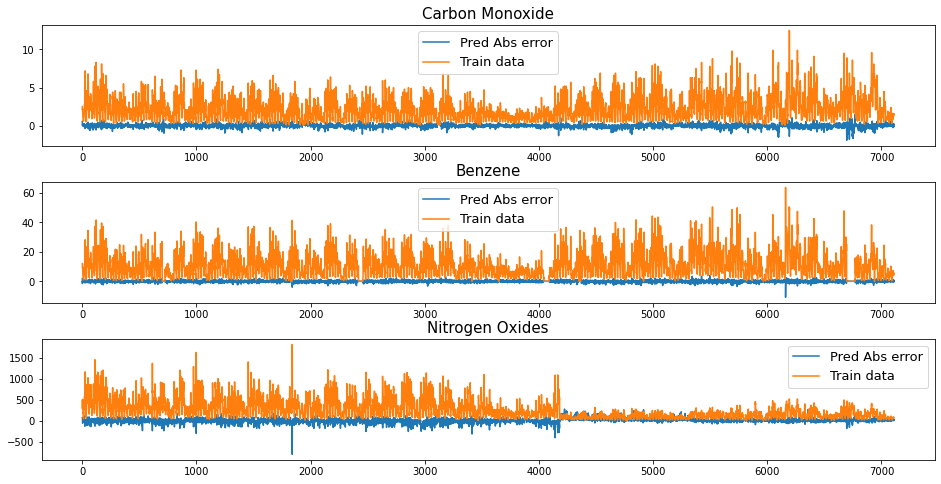

In [36]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 8))
plt.set_cmap("Set2")
plt.subplots_adjust(hspace = 0.3)

pred_cm = model_cm.predict(X)
pred_be = model_be.predict(X)
pred_no = model_no.predict(X) #.iloc[4182:,]


axs[0].plot(np.arange(0, pred_cm.shape[0], 1), pred_cm - y[target_columns[0]], label="Pred Abs error")
axs[0].plot(np.arange(0, pred_cm.shape[0], 1), y[target_columns[0]], label="Train data")
axs[0].set_title("Carbon Monoxide", fontsize=15)
axs[0].legend(fontsize=13)

axs[1].plot(np.arange(0, pred_be.shape[0], 1), pred_be - y[target_columns[1]], label="Pred Abs error")
axs[1].plot(np.arange(0, pred_be.shape[0], 1), y[target_columns[1]], label="Train data")
axs[1].set_title("Benzene", fontsize=15)
axs[1].legend(fontsize=13)

axs[2].plot(np.arange(0, pred_no.shape[0], 1), pred_no - y[target_columns[2]], label="Pred Abs error")
axs[2].plot(np.arange(0, pred_no.shape[0], 1), y[target_columns[2]], label="Train data")
axs[2].set_title("Nitrogen Oxides", fontsize=15)
axs[2].legend(fontsize=13)

In [34]:
#pred_no = model_no.predict(X) #.iloc[4182:,]
print(mean(y[target_columns[2]].iloc[4182:,])/2.86)
print(mean(y[target_columns[2]].iloc[:4181,]))

40.422601396463605
115.43420234393686


# OLD STUFF

In [283]:


#feature generation
data = GenerateFeatures(data)

# prepare the data
target_columns = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides' ]

y = data[target_columns]
X = data[data.columns.difference(target_columns)]
#X.date_time = X.date_time.astype(str)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

#create pipelines
numerical_columns_selector = selector(dtype_include='float64')
numerical_columns = numerical_columns_selector(X_train)

dates_pipeline = Pipeline([
        ('date_formatter', DateFormatter()), ('date_encoder', DateTransformer())
        ])

ct = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), numerical_columns),
        #('poly_feat_gen', PolynomialFeatures(), numerical_columns),
        ('date_expansion', dates_pipeline, ['date_time']),
    ]
)

ct_ohe = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [9]) #to apply in a sequence to one of the generated variables
    ],
    remainder='passthrough'
)

#new_feature_generator = Pipeline(steps= [ ('humidity_selector', FeatureSelector(['absolute_humidity', 'relative_humidity'])),
#                                          ('new_smc_feature', FeatureGenerationTransformer(['absolute_humidity', 'relative_humidity'])) ])

pipeline_cm = make_pipeline(ct, ct_ohe, lgb.LGBMRegressor(n_estimators=150, max_depth=20, learning_rate=0.05, random_state=42))
pipeline_benz = make_pipeline(ct, ct_ohe, lgb.LGBMRegressor(n_estimators=200, max_depth=20, learning_rate=0.05, random_state=42))
pipeline_no = make_pipeline(ct, ct_ohe, lgb.LGBMRegressor(n_estimators=150, max_depth=20, learning_rate=0.05, random_state=42))

#pipeline_cm
#pipeline_cm['columntransformer']

In [253]:
pipeline_cm

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('humidity_selector',
                                  FeatureSelector(feature_names=['absolute_humidity',
                                                                 'relative_humidity'])),
                                 ('new_smc_feature',
                                  FeatureGenerationTransformer(feature_names=['absolute_humidity',
                                                                              'relative_humidity']))])),
                ('columntransformer-1',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['absolute_humidity', '...
                                                  Pipeline(steps=[('date_formatter',
                                                                   <__main__.DateFormatter object at 0x000001F218D8B0A0>),
                                                                  ('date_encoder',
                                                                   DateTransformer())]),
                                                  ['date_time'])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  [9])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.05, max_depth=20,
                               n_estimators=150, random_state=42))])

In [254]:
#FeatureGenerationTransformer().fit_transform(X_train)
#X_train

In [255]:
pipeline_cm.fit(X_train, y_train[target_columns[0]])
print("Trained pipeline_cm")

pipeline_benz.fit(X_train, y_train[target_columns[1]])
print("Trained pipeline_benz")

pipeline_no.fit(X_train, y_train[target_columns[2]])
print("Trained pipeline_no")

FeatureGenerationTransformer.transform <class 'pandas.core.frame.DataFrame'>
FeatureGenerationTransformer.transform 1
      absolute_humidity  relative_humidity
1360             0.8833               35.8
418              0.7124               64.9
3717             1.7537               29.1
5603             1.5030               76.5
1514             0.8920               46.3
...                 ...                ...
3772             1.7075               47.7
5191             0.9517               58.2
5226             1.0399               41.2
5390             1.6645               58.9
860              0.7826               34.6

[5333 rows x 2 columns]
1360    2.467318
418     1.097689
3717    6.026460
5603    1.964706
1514    1.926566
          ...   
3772    3.579665
5191    1.635223
5226    2.524029
5390    2.825976
860     2.261850
Length: 5333, dtype: float64
FeatureGenerationTransformer.transform 2
FeatureGenerationTransformer.transform 3
      absolute_humidity  relative_humidity 

ValueError: A given column is not a column of the dataframe

In [256]:
from sklearn.metrics import mean_squared_log_error
import math

pred_cm = pipeline_cm.predict(X_test) #[numerical_columns]
pred_benz = pipeline_benz.predict(X_test)
#pred_benz = np.where((pred_benz < 0.3), 0.1, pred_benz) # martelar os valores da pred_benz - tem impacto muito pequeno
pred_no = pipeline_no.predict(X_test)

#pred_cm = log_target_transform_cm.predict(X_test)
#pred_benz = log_target_transform_benz.predict(X_test)
#pred_no = log_target_transform_no.predict(X_test)


# https://stackoverflow.com/questions/57839824/how-to-pre-process-the-data-to-calculate-root-mean-squared-logarithmic-error
# this fails if negative predictions < -1.0 / keeps happening with no
error_cm = NumPyRMSLE(y_test[target_columns[0]].tolist(), pred_cm.tolist())   # mean_squared_log_error(y_test[target_columns[0]], pred_cm)
error_benz = NumPyRMSLE(y_test[target_columns[1]].tolist(), pred_benz.tolist())
error_no = NumPyRMSLE(y_test[target_columns[2]].tolist(), pred_no.tolist())

print("RMSLE CM:", error_cm)
print("RMSLE BE:",error_benz)
print("RMSLE NO:",error_no)
print("Mean: ", ((error_cm + error_benz + error_no)/3), " SUM: ", error_cm + error_benz + error_no)

FeatureGenerationTransformer.transform <class 'pandas.core.frame.DataFrame'>
FeatureGenerationTransformer.transform 1
      absolute_humidity  relative_humidity
2755             0.9177               16.1
3437             1.6304               43.3
6472             0.9564               66.0
3126             1.1396               28.8
5858             0.8678               80.4
...                 ...                ...
4401             1.1491               37.7
121              1.0086               39.5
3347             0.9982               43.2
3834             1.2502               21.5
3599             1.8037               29.2

[1778 rows x 2 columns]
2755    5.700000
3437    3.765358
6472    1.449091
3126    3.956944
5858    1.079353
          ...   
4401    3.048011
121     2.553418
3347    2.310648
3834    5.814884
3599    6.177055
Length: 1778, dtype: float64
FeatureGenerationTransformer.transform 2
FeatureGenerationTransformer.transform 3
      absolute_humidity  relative_humidity 

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

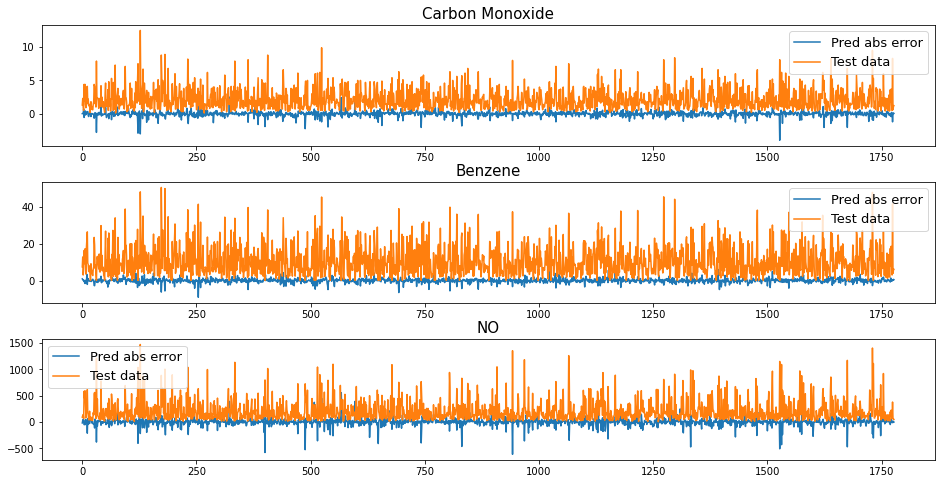

In [34]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 8))
plt.set_cmap("Set2")
plt.subplots_adjust(hspace = 0.3)

axs[0].plot(np.arange(0, pred_benz.shape[0], 1), pred_cm - y_test[target_columns[0]], label="Pred abs error")
axs[0].plot(np.arange(0, pred_cm.shape[0], 1), y_test[target_columns[0]], label="Test data")
axs[0].set_title("Carbon Monoxide", fontsize=15)
axs[0].legend(fontsize=13)

axs[1].plot(np.arange(0, pred_benz.shape[0], 1), pred_benz - y_test[target_columns[1]], label="Pred abs error")
axs[1].plot(np.arange(0, pred_benz.shape[0], 1), y_test[target_columns[1]], label="Test data")
axs[1].set_title("Benzene", fontsize=15)
axs[1].legend(fontsize=13)

axs[2].plot(np.arange(0, pred_no.shape[0], 1), pred_no - y_test[target_columns[2]], label="Pred abs error")
axs[2].plot(np.arange(0, pred_no.shape[0], 1), y_test[target_columns[2]], label="Test data")
axs[2].set_title("NO", fontsize=15)
axs[2].legend(fontsize=13)

In [257]:
test_data = pd.read_csv('data/test.csv')

# make submission predictions
#test_data.date_time = test_data.date_time.astype(str) #EBR's don't support datetimes

holdout_pred_cm = pipeline_cm.predict(test_data[['absolute_humidity', 'date_time', 'deg_C', 'relative_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']])
holdout_pred_benz = pipeline_benz.predict(test_data[['absolute_humidity', 'date_time', 'deg_C', 'relative_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']])
holdout_pred_no = pipeline_no.predict(test_data[['absolute_humidity', 'date_time', 'deg_C', 'relative_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']])

#holdout_pred_cm = search_cm.predict(test_data[['absolute_humidity', 'date_time', 'deg_C', 'relative_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']])
#holdout_pred_benz = search_benz.predict(test_data[['absolute_humidity', 'date_time', 'deg_C', 'relative_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']])
#holdout_pred_no = search_no.predict(test_data[['absolute_humidity', 'date_time', 'deg_C', 'relative_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']])

#holdout_pred_cm = log_target_transform_cm.predict(test_data) #[numerical_columns]
#holdout_pred_benz = log_target_transform_benz.predict(test_data)
#holdout_pred_no = log_target_transform_no.predict(test_data)



#print(holdout_pred_cm[holdout_pred_cm], holdout_pred_benz[holdout_pred_benz], holdout_pred_no[holdout_pred_no]) 

FeatureGenerationTransformer.transform <class 'pandas.core.frame.DataFrame'>
FeatureGenerationTransformer.transform 1
      absolute_humidity  relative_humidity
0                0.4375               41.3
1                0.4564               51.7
2                0.4689               51.5
3                0.4693               52.3
4                0.4650               57.5
...                 ...                ...
2242             0.7568               28.7
2243             0.7119               22.5
2244             0.6406               19.0
2245             0.5139               12.7
2246             0.5028               13.5

[2247 rows x 2 columns]
0       1.059322
1       0.882785
2       0.910485
3       0.897323
4       0.808696
          ...   
2242    2.636934
2243    3.164000
2244    3.371579
2245    4.046457
2246    3.724444
Length: 2247, dtype: float64
FeatureGenerationTransformer.transform 2
FeatureGenerationTransformer.transform 3
      absolute_humidity  relative_humidity 

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [ ]:
test_data['target_carbon_monoxide'] = holdout_pred_cm
test_data['target_benzene'] = holdout_pred_benz
test_data.target_benzene = np.where((test_data.target_benzene < 0.3), 0.1, test_data.target_benzene)
test_data['target_nitrogen_oxides'] = holdout_pred_no
data_to_save = test_data.drop(numerical_columns, axis=1)

In [ ]:
data_to_save.reset_index()
data_to_save.to_csv('data/holdout_predictions.csv', index=False)